# Creación de indicadores basados en el censo

En esta etapa se crean indicadores basados en datos del Censo Nacional 2010 y cartografía censal. Las tareas realizadas en este notebook cumplen el rol de inicializar los archivos CSV que serán la base de datos de los indicadores para cada nivel de agregación y crean un conjunto de indicadores basados en en el CNPV2010.

Utilizando el paquete `pyredatam` se pueden descargar y utilizar fácilmente frecuencias simples de las variables del Censo así como realizar consultas más complejas a la base REDATAM.

In [1]:
import pyredatam
from pyredatam import cpv2010arg
import os
import pandas as pd
import numpy as np
from tabulate import tabulate
from sklearn.decomposition import PCA
from scripts.path_finders import get_indicators_path, get_division_path, get_transport_shp_path
from scripts.create_indicators import get_data, replace_index, get_or_create_indicators_df, get_data_from_query
from scripts.geo_utils import join_df_with_shp, get_shapely_shape, iter_shp_as_shapely
from scripts.global_vars import IDS_GCBA, AREA_LEVEL_SHP_NAME
%matplotlib inline
import matplotlib
matplotlib.style.use("ggplot")

PyTables is not installed. No support for HDF output.


## Carga de datos censales

Cargamos todos los datos necesarios de la base REDATAM en dataframes. El método `get_data` descarga los datos de la base del Censo 2010 (es necesario tener Firefox instalado), a menos que ya estén en la carpeta *data/censo*.

In [2]:
variables = ["PERSONA.CONDACT", "VIVIENDA.V02", "PERSONA.EDADAGRU",
             "VIVIENDA.INCALCONS", "VIVIENDA.INCALSERV", "HOGAR.ALGUNBI", 
             "HOGAR.INDHAC", "HOGAR.H19A", "HOGAR.H19B", "HOGAR.H19C", 
             "HOGAR.H19D", "HOGAR.H05", "HOGAR.H12", "PERSONA.P02", "PERSONA.P05"]

In [3]:
dfs_radio = [get_data("RADIO", variable, redownload=False) for variable in variables]
dfs_frac = [get_data("FRAC", variable, redownload=False) for variable in variables]
dfs_comuna = [get_data("DPTO", variable, redownload=False) for variable in variables]
dfs_caba = [get_data("PROV", variable, redownload=False) for variable in variables]

## Chequeos de consistencia

La cantidad de radios, fracciones, comunas y Ciudades de Buenos Aires (1 sola), debe coincidir para todas las variables censales descargadas.

In [4]:
print "RADIO # de radios", [len(df_radio) for df_radio in dfs_radio]
print "FRAC # de fracciones", [len(df_frac) for df_frac in dfs_frac]
print "DPTO # de comunas", [len(df_comuna) for df_comuna in dfs_comuna]
print "PROV # de CABAs", [len(df_caba) for df_caba in dfs_caba]

RADIO # de radios [3553, 3553, 3553, 3553, 3553, 3553, 3553, 3553, 3553, 3553, 3553, 3553, 3553, 3553, 3553]
FRAC # de fracciones [351, 351, 351, 351, 351, 351, 351, 351, 351, 351, 351, 351, 351, 351, 351]
DPTO # de comunas [15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15]
PROV # de CABAs [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


La suma del total de casos para cada variable censal debe coincidir en distintos niveles de agregación.

In [5]:
for df_frac, df_radio, df_comuna, df_caba, variable in zip(dfs_frac, dfs_radio, dfs_comuna, dfs_caba, variables):
    
    total_frac = sum(df_frac["Total"])
    total_radio = sum(df_radio["Total"])
    total_comuna = sum(df_comuna["Total"])
    total_caba = sum(df_caba["Total"])
    
    print variable.ljust(18), total_radio, total_frac, total_comuna, total_caba, 
    print total_radio == total_frac == total_comuna == total_caba

PERSONA.CONDACT    2390725.0 2390725.0 2390725.0 2390725.0 True
VIVIENDA.V02       1423973.0 1423973.0 1423973.0 1423973.0 True
PERSONA.EDADAGRU   2890151.0 2890151.0 2890151.0 2890151.0 True
VIVIENDA.INCALCONS 1082998.0 1082998.0 1082998.0 1082998.0 True
VIVIENDA.INCALSERV 1082998.0 1082998.0 1082998.0 1082998.0 True
HOGAR.ALGUNBI      1150134.0 1150134.0 1150134.0 1150134.0 True
HOGAR.INDHAC       1150134.0 1150134.0 1150134.0 1150134.0 True
HOGAR.H19A         1150134.0 1150134.0 1150134.0 1150134.0 True
HOGAR.H19B         1150134.0 1150134.0 1150134.0 1150134.0 True
HOGAR.H19C         1150134.0 1150134.0 1150134.0 1150134.0 True
HOGAR.H19D         1150134.0 1150134.0 1150134.0 1150134.0 True
HOGAR.H05          1150134.0 1150134.0 1150134.0 1150134.0 True
HOGAR.H12          1140209.0 1140209.0 1140209.0 1140209.0 True
PERSONA.P02        2890151.0 2890151.0 2890151.0 2890151.0 True
PERSONA.P05        2890151.0 2890151.0 2890151.0 2890151.0 True


## 1. Creación de indicadores censales

Carga el CSV de indicadores para cada nivel de agregación, si existe. Si no existe, crea uno a imagen y semejanza del dataframe generado por el scrapeo a la base REDATAM.

In [6]:
indicators_radio = get_or_create_indicators_df("RADIO", dfs_radio[0])
indicators_frac = get_or_create_indicators_df("FRAC", dfs_frac[0])
indicators_comuna = get_or_create_indicators_df("DPTO", dfs_comuna[0])
indicators_caba = get_or_create_indicators_df("PROV", dfs_caba[0])

In [7]:
indicators_radio.head()

,inact,ocup_viv,0_14,15_64,mas_65,hab,con_satisf,con_basica,con_insuf,serv_satisf,...,hab_km2,reach_prop,CO_FRAC_RA,empleo,DECIL,desocup,hombres,extranjeros,AREA,area_km2
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
020010101,0.118056,0.703704,0.142857,0.824405,0.032738,336,0.447368,0.289474,0.263158,0.894737,...,186.757597,0.194008,1_1_1,0.652778,7,0.035897,0.630952,0.264881,1799123.599990,1.799124
020010201,0.300912,0.905405,0.311715,0.661088,0.027197,478,0.074627,0.492537,0.432836,0.776119,...,17463.512282,0.099636,1_2_1,0.680851,2,0.050847,0.485356,0.175732,27371.355331,0.027371
020010202,0.347170,0.950000,0.339152,0.648379,0.012469,401,0.087719,0.482456,0.429825,0.842105,...,22697.854578,0.058109,1_2_2,0.615094,1,0.084270,0.468828,0.254364,17666.867969,0.017667
020010203,0.334764,0.942308,0.308605,0.673591,0.017804,337,0.081633,0.438776,0.479592,0.857143,...,30540.237453,0.057675,1_2_3,0.639485,3,0.102410,0.504451,0.157270,11034.622783,0.011035
020010204,0.280000,0.924370,0.335548,0.649502,0.014950,602,0.118182,0.600000,0.281818,0.927273,...,4380.790660,0.100349,1_2_4,0.727500,3,0.058252,0.493355,0.119601,137418.116194,0.137418


Métodos que toman un dataframe con indicadores y los dataframes con los datos originales para crear indicadores.

In [8]:
def calculate_indicators_CONDACT(df_indicators, df_condact, df_edadgru):
    pobl_14_mas = df_edadgru["Total"] - df_edadgru["0 - 14"]
    pea = df_condact["Ocupado"] + df_condact["Desocupado"]
    df_indicators["empleo"] = df_condact["Ocupado"] / pobl_14_mas
    df_indicators["desocup"] = df_condact["Desocupado"] / pea
    df_indicators["inact"] = df_condact["Inactivo"] / pobl_14_mas

def calculate_indicators_V02(df_indicators, df):
    df_indicators["ocup_viv"] = df["Con personas presentes"] / df["Total"]

def calculate_indicators_EDADGRU(df_indicators, df):
    df_indicators["0_14"] = df["0 - 14"] / df["Total"]
    df_indicators["15_64"] = df["15 - 64"] / df["Total"]
    df_indicators["mas_65"] = df["65 y más".decode("utf-8")] / df["Total"]
    df_indicators["hab"] = df["Total"]

def calculate_indicators_INCALCONS(df_indicators, df):
    df_indicators["con_satisf"] = df["Satisfactoria"] / df["Total"]
    df_indicators["con_basica"] = df["Básica".decode("utf-8")] / df["Total"]
    df_indicators["con_insuf"] = df["Insuficiente"] / df["Total"]

def calculate_indicators_INCALSERV(df_indicators, df):
    df_indicators["serv_satisf"] = df["Satisfactoria"] / df["Total"]
    df_indicators["serv_basica"] = df["Básica".decode("utf-8")] / df["Total"]
    df_indicators["serv_insuf"] = df["Insuficiente"] / df["Total"]

def calculate_indicators_ALGUNBI(df_indicators, df):
    df_indicators["nbi"] = df["Hogares con NBI"] / df["Total"]

def calculate_indicators_INDHAC(df_indicators, df):
    df_indicators["hac-149"] = sum((df["Hasta   0.50 personas por cuarto"],
                                                df["0.51  -  0.99  personas por cuarto"],
                                                df["1.00  -  1.49  personas por cuarto"])) / df["Total"]
    
    df_indicators["hac+150"] = sum((df["1.50  -  1.99  personas por cuarto"],
                                                df["2.00  -  3.00  personas por cuarto"],
                                                df["Más de  3.00 personas por cuarto".decode("utf-8")])) / df["Total"]

def calculate_indicators_P02(df_indicators, df):
    df_indicators["hombres"] = df["Varón".decode("utf-8")] / df["Total"]

def calculate_indicators_P05(df_indicators, df):
    df_indicators["extranjeros"] = df["Otro país".decode("utf-8")] / df["Total"]

Se calculan todos los indicadores simples derivados de datos censales.

In [9]:
def calculate_indicators(dfs, df_indicators):
    calculate_indicators_CONDACT(df_indicators, dfs[0], dfs[2])
    calculate_indicators_V02(df_indicators, dfs[1])
    calculate_indicators_EDADGRU(df_indicators, dfs[2])
    calculate_indicators_INCALCONS(df_indicators, dfs[3])
    calculate_indicators_INCALSERV(df_indicators, dfs[4])
    calculate_indicators_ALGUNBI(df_indicators, dfs[5])
    calculate_indicators_INDHAC(df_indicators, dfs[6])
    calculate_indicators_P02(df_indicators, dfs[13])
    calculate_indicators_P05(df_indicators, dfs[14])

calculate_indicators(dfs_radio, indicators_radio)
calculate_indicators(dfs_frac, indicators_frac)
calculate_indicators(dfs_comuna, indicators_comuna)
calculate_indicators(dfs_caba, indicators_caba)

In [10]:
indicators_radio.head()

,inact,ocup_viv,0_14,15_64,mas_65,hab,con_satisf,con_basica,con_insuf,serv_satisf,...,hab_km2,reach_prop,CO_FRAC_RA,empleo,DECIL,desocup,hombres,extranjeros,AREA,area_km2
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
020010101,0.118056,0.703704,0.142857,0.824405,0.032738,336,0.447368,0.289474,0.263158,0.894737,...,186.757597,0.194008,1_1_1,0.652778,7,0.035897,0.630952,0.264881,1799123.599990,1.799124
020010201,0.300912,0.905405,0.311715,0.661088,0.027197,478,0.074627,0.492537,0.432836,0.776119,...,17463.512282,0.099636,1_2_1,0.680851,2,0.050847,0.485356,0.175732,27371.355331,0.027371
020010202,0.347170,0.950000,0.339152,0.648379,0.012469,401,0.087719,0.482456,0.429825,0.842105,...,22697.854578,0.058109,1_2_2,0.615094,1,0.084270,0.468828,0.254364,17666.867969,0.017667
020010203,0.334764,0.942308,0.308605,0.673591,0.017804,337,0.081633,0.438776,0.479592,0.857143,...,30540.237453,0.057675,1_2_3,0.639485,3,0.102410,0.504451,0.157270,11034.622783,0.011035
020010204,0.280000,0.924370,0.335548,0.649502,0.014950,602,0.118182,0.600000,0.281818,0.927273,...,4380.790660,0.100349,1_2_4,0.727500,3,0.058252,0.493355,0.119601,137418.116194,0.137418


In [11]:
indicators_frac.head()

,desocup,inact,ocup_viv,0_14,15_64,mas_65,hab,con_satisf,con_basica,con_insuf,...,nse_alt,RESIDENCIAL,reach_prop,empleo,DECIL,hombres,extranjeros,AREA,area_km2,CO_FRACC
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
0200101,0.035897,0.118056,0.703704,0.142857,0.824405,0.032738,336,0.447368,0.289474,0.263158,...,5.000000,0.156990,0.194008,0.652778,7.000000,0.630952,0.264881,1798815.168600,1.798815,001_1
0200102,0.072142,0.272439,0.953185,0.298408,0.686116,0.015476,11243,0.118538,0.477843,0.403619,...,6.000000,0.302362,0.036308,0.694599,2.162234,0.501023,0.365650,420517.245560,0.420517,001_2
0200103,0.066722,0.239014,0.929540,0.321379,0.669561,0.009060,15894,0.066384,0.305085,0.628531,...,6.797659,0.000000,0.032491,0.728815,1.050145,0.509249,0.643891,879689.833551,0.879690,001_3
0200104,0.033735,0.293582,0.588288,0.131198,0.650685,0.218117,10366,0.935988,0.054824,0.009188,...,2.331372,0.457130,0.107868,0.667888,9.865618,0.434497,0.147501,201529.283085,0.201529,001_4
0200105,0.040000,0.286498,0.592682,0.124492,0.657739,0.217769,5414,0.926010,0.067181,0.006809,...,1.445696,0.392654,0.211026,0.632911,10.000000,0.427595,0.129849,198345.373779,0.198345,001_5


In [12]:
indicators_comuna.head()

,empleo,desocup,inact,ocup_viv,0_14,15_64,mas_65,hab,con_satisf,con_basica,...,esp_verde,nse_alt,RESIDENCIAL,reach_prop,COMUNAS,DECIL,hombres,extranjeros,AREA,area_km2
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
02001,0.660940,0.045429,0.230967,0.599215,0.154119,0.704424,0.141457,205886,0.754696,0.135260,...,0.169683,3.605243,0.229715,0.198697,1,7.495065,0.476463,0.247457,17800337.75420,17.800338
02002,0.674582,0.037593,0.270640,0.656395,0.110187,0.691848,0.197965,157932,0.918893,0.070327,...,0.067829,1.978142,0.372358,0.153702,2,9.951093,0.430831,0.098276,6297217.45692,6.297217
02003,0.697068,0.042838,0.251149,0.747373,0.149848,0.690034,0.160118,187537,0.856028,0.100007,...,0.009346,3.370039,0.437444,0.223716,3,8.186523,0.456449,0.162453,6385016.64068,6.385017
02004,0.679359,0.054524,0.287690,0.840267,0.209613,0.661541,0.128846,218245,0.728660,0.183396,...,0.070126,4.122275,0.559249,0.181907,4,6.052372,0.472707,0.177699,21645921.44460,21.645921
02005,0.704394,0.039907,0.254873,0.789499,0.145024,0.682914,0.172062,179005,0.883648,0.092044,...,0.003275,3.187503,0.654641,0.218783,5,8.975369,0.451418,0.106014,6659057.73236,6.659058


In [13]:
indicators_caba.head()

,empleo,desocup,inact,ocup_viv,0_14,15_64,mas_65,hab,con_satisf,con_basica,...,esp_verde,nse_alt,RESIDENCIAL,area_km2,hab_km2,AREA,reach_prop,DECIL,hombres,extranjeros
Código,,,,,,,,,,,,,,,,,,,,,
02,0.68422,0.042921,0.273963,0.760547,0.16349,0.67248,0.16403,2890151,0.856398,0.109963,...,0.1053,3.245048,0.551233,203.760736,28876.703407,2.037607e+08,0.17457,8.300183,0.460073,0.132096


### 2. Indicador de nivel socioeconómico

#### 2.a) Versión adaptada y modificada de DOT México

Esta metodología es una adaptación con modificaciones de la utilizada por el ITDP de México (Instituto de Políticas para el Transporte y el Desarrollo) para la estimación del nivel socioeconómico de un área geoestadística básica (AGEB) de la Zona Metropolitana del Valle de México (ZMVM).

En líneas generales, consiste en realizar un análisis de componentes principales a partir de tres índices que reflejan diferentes aspectos del nivel socioeconómico de un radio censal de la Ciudad. 

##### *Índice de escolaridad*

In [14]:
df_asist_educ = get_data("RADIO", "PERSONA.P08", "PERSONA.EDAD < 18")

In [15]:
def calculate_escolaridad_indicator(df_indicators, df_asist_educ):
    df_indicators["escolaridad"] = df_asist_educ["Asiste"] / df_asist_educ["Total"]

In [16]:
calculate_escolaridad_indicator(indicators_radio, df_asist_educ)

In [17]:
indicators_radio["escolaridad"].head()

Unnamed: 0
020010101    0.843137
020010201    0.867647
020010202    0.862595
020010203    0.843137
020010204    0.903382
Name: escolaridad, dtype: float64

##### *Índice de educación superior*

In [18]:
df_educ_sup = get_data("RADIO", "PERSONA.P09", "PERSONA.EDAD > 25 AND PERSONA.P10 = 1")

In [19]:
def calculate_educ_sup_indicator(df_indicators, df_educ_sup):
    df_indicators["educ_sup"] = (df_educ_sup["Universitario"] + df_educ_sup["Post universitario"]) / df_educ_sup["Total"]

In [20]:
calculate_educ_sup_indicator(indicators_radio, df_educ_sup)

In [21]:
indicators_radio["educ_sup"].head()

Unnamed: 0
020010101    0.102362
020010201    0.056911
020010202    0.022222
020010203    0.039474
020010204    0.008929
Name: educ_sup, dtype: float64

##### *Índice de computadora*

In [22]:
df_compu = get_data("RADIO", "HOGAR.H19B", "HOGAR.H19A = 1 OR HOGAR.H19B = 1 OR HOGAR.H19C = 1 OR HOGAR.H19D = 1")

In [23]:
def calculate_compu_indicator(df_indicators, df_compu):
    df_indicators["compu"] = df_compu["Sí".decode("utf-8")] / df_compu["Total"]

In [24]:
calculate_compu_indicator(indicators_radio, df_compu)

In [25]:
indicators_radio["compu"].head()

Unnamed: 0
020010101    0.500000
020010201    0.280000
020010202    0.192000
020010203    0.438776
020010204    0.432258
Name: compu, dtype: float64

##### **Índice de Nivel Socio-Económico basado en el primer componente principal**

In [26]:
df_nse_mexico = indicators_radio[["educ_sup", "escolaridad", "compu"]]

In [27]:
df_nse_mexico.head()

,educ_sup,escolaridad,compu
Unnamed: 0,,,
020010101,0.102362,0.843137,0.500000
020010201,0.056911,0.867647,0.280000
020010202,0.022222,0.862595,0.192000
020010203,0.039474,0.843137,0.438776
020010204,0.008929,0.903382,0.432258


In [28]:
# correlación entre los tres índices
df_nse_mexico.corr()

,educ_sup,escolaridad,compu
educ_sup,1.000000,0.496032,0.792191
escolaridad,0.496032,1.000000,0.648060
compu,0.792191,0.648060,1.000000


In [96]:
# imprime tabla de correlaciones para markdown
print tabulate(df_nse_mexico.corr(), tablefmt="pipe", headers=["educ_sup", "escolaridad", "compu"])

|             |   educ_sup |   escolaridad |    compu |
|:------------|-----------:|--------------:|---------:|
| educ_sup    |   1        |      0.496032 | 0.792191 |
| escolaridad |   0.496032 |      1        | 0.64806  |
| compu       |   0.792191 |      0.64806  | 1        |


In [30]:
df_nse_mexico_clean = df_nse_mexico.dropna()

Se realiza un análisis de componentes principales sobre los índices construidos.

In [31]:
pca = PCA(n_components=3)
pca.fit(df_nse_mexico_clean)

PCA(copy=True, n_components=3, whiten=False)

In [32]:
pca.explained_variance_ratio_

array([ 0.88315721,  0.10113534,  0.01570745])

In [33]:
params_pc1 = pca.components_[0]
pca.components_

array([[ 0.76120783,  0.10759338,  0.63952037],
       [ 0.64799446, -0.16542885, -0.74346249],
       [-0.02580348, -0.98033513,  0.19564565]])

Se calcula el NSE de dos maneras: utilizando los parámetros del primer componente principal y haciendo un promedio simple de los tres índices.

In [34]:
df_nse_mexico_clean["nse_mex"] = df_nse_mexico_clean.dot(params_pc1)
df_nse_mexico_clean["nse_mex_av"] = (df_nse_mexico_clean["educ_sup"] + 
                                     df_nse_mexico_clean["escolaridad"] + 
                                     df_nse_mexico_clean["compu"]) / 3

/Users/abenassi/anaconda/envs/tod/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/abenassi/anaconda/envs/tod/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Los índices correlacionan fuertemente con educación superior y computadora, un poco menos con escolaridad. El indicador de NSE basado en el análisis de PCA correlaciona casi perfectamente con el realizado como un promedio simple entre los tres índices utilizados.

In [35]:
df_nse_mexico_clean.corr()

,educ_sup,escolaridad,compu,nse_mex,nse_mex_av
educ_sup,1.000000,0.496032,0.792132,0.960914,0.941003
escolaridad,0.496032,1.000000,0.648060,0.603323,0.671367
compu,0.792132,0.648060,1.000000,0.929909,0.944568
nse_mex,0.960914,0.603323,0.929909,1.000000,0.995746
nse_mex_av,0.941003,0.671367,0.944568,0.995746,1.000000


Se continúa utilizando el indicador de NSE basado en el análisis de componentes principales.

In [36]:
serie = df_nse_mexico_clean["nse_mex"]

Normalizamos el índice de nivel socioeconómico y lo reexpresamos en una escala de 0 a 10, para mejorar su interpretación.

In [37]:
print "Antes de la normalización", indicators_radio.nse_mex.min(), indicators_radio.nse_mex.max()

Antes de la normalización 0.0 10.0


In [38]:
indicators_radio.nse_mex = indicators_radio.nse_mex / indicators_radio.nse_mex.max() * 10

In [39]:
print "Después de la normalización", indicators_radio.nse_mex.min(), indicators_radio.nse_mex.max()

Después de la normalización 0.0 10.0


In [40]:
# chequeamos que no haya radios censales repetidos
len(indicators_radio.index), len(set(indicators_radio.index))

(3554, 3554)

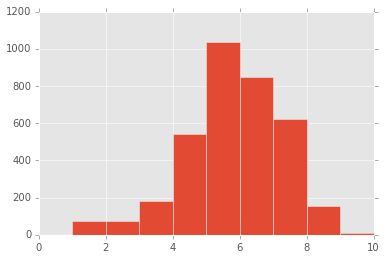

In [41]:
indicators_radio.nse_mex.hist()

#### 2.b) Versión alternativa de NSE basada en una estratificación de la población por sus características

Esta versión alternativa establece una serie de criterios que actúan como un árbol de decisión que genera una clasificación de NSE con 7 estratos.

Se crea un nuevo dataframe con el mismo índice que el de indicadores de radios censales.

In [42]:
nse_alt = pd.DataFrame(index=indicators_radio.index)

*Criterio 2*

% de jefes de hogar con estudios universitarios o post-universitarios

In [43]:
query_educ_jefes = """
RUNDEF programa 
    SELECTION INLINE,
        PROV 02

DEFINE RADIO.COUNTER
    AS COUNT HOGAR
    TYPE INTEGER

DEFINE HOGAR.EDUCJEFE 
    AS PERSONA.P09
    FOR PERSONA.P01 = 1 
    RANGE 1-9
    TYPE INTEGER
    VARLABEL "Nivel educativo del jefe del hogar"

DEFINE HOGAR.JEFETER
    AS PERSONA.P10
    FOR PERSONA.P01 = 1 
    RANGE 1-2
    TYPE INTEGER
    VARLABEL "Jefe de hogar terminó el nivel educativo" 
    
DEFINE HOGAR.JEFEUNIV
    AS ((HOGAR.EDUCJEFE = 7 AND HOGAR.JEFETER = 1) OR HOGAR.EDUCJEFE = 8)
    TYPE INTEGER
    RANGE 0-1

TABLE T1
    AS AREALIST 
    OF RADIO, RADIO.COUNTER, HOGAR.JEFEUNIV
"""

In [44]:
df_educ_jefes = get_data_from_query("RADIO", query_educ_jefes, redownload=False)
df_educ_jefes.head()

,COUNTER,0,1,Total,CO_FRAC_RA
Código,,,,,
020010101,93,81,7,88,1_1_1
020010201,162,154,4,158,1_2_1
020010202,132,126,2,128,1_2_2
020010203,104,100,1,101,1_2_3
020010204,164,158,0,158,1_2_4


In [45]:
hogares_contestaron = df_educ_jefes["Total"].sum()
hogares_totales = df_educ_jefes["COUNTER"].sum()
print hogares_contestaron, hogares_totales, hogares_contestaron / hogares_totales

1141371.0 1152599.0 0.990258537445


In [46]:
df_educ_jefes["ratio"] = df_educ_jefes["1"] / df_educ_jefes["Total"]
df_educ_jefes.head()

,COUNTER,0,1,Total,CO_FRAC_RA,ratio
Código,,,,,,
020010101,93,81,7,88,1_1_1,0.079545
020010201,162,154,4,158,1_2_1,0.025316
020010202,132,126,2,128,1_2_2,0.015625
020010203,104,100,1,101,1_2_3,0.009901
020010204,164,158,0,158,1_2_4,0.000000


In [47]:
df_educ_jefes["1"].sum() / df_educ_jefes["Total"].sum()

0.23612392464851481

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10c059610>]], dtype=object)

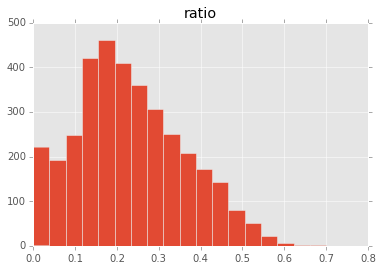

In [48]:
df_educ_jefes.hist("ratio", bins=18)

% de hogares con servicio doméstico con cama

In [49]:
query_serv_dom = """
RUNDEF programa 
    SELECTION INLINE,
        PROV 02

DEFINE RADIO.COUNTER
    AS COUNT HOGAR
    TYPE INTEGER

DEFINE HOGAR.SDOMCANT
    AS COUNT PERSONA
    FOR (PERSONA.P01 = 9)
    TYPE INTEGER

DEFINE HOGAR.SERVDOM
    AS HOGAR.SDOMCANT > 0
    TYPE INTEGER
    RANGE 0-1
    
TABLE T1
    AS AREALIST 
    OF RADIO, RADIO.COUNTER, HOGAR.SERVDOM
"""

In [50]:
df_serv_dom = get_data_from_query("RADIO", query_serv_dom, redownload=False)
df_serv_dom.head()

,COUNTER,0,1,Total,CO_FRAC_RA
Código,,,,,
020010101,93,93,0,93,1_1_1
020010201,162,162,0,162,1_2_1
020010202,132,132,0,132,1_2_2
020010203,104,104,0,104,1_2_3
020010204,164,164,0,164,1_2_4


In [51]:
hogares_contestaron = df_serv_dom["Total"].sum()
hogares_totales = df_serv_dom["COUNTER"].sum()
print hogares_contestaron, hogares_totales, hogares_contestaron / hogares_totales

1152599.0 1152599.0 1.0


In [52]:
df_serv_dom["ratio"] = df_serv_dom["1"] / df_serv_dom["Total"]
df_serv_dom.head()

,COUNTER,0,1,Total,CO_FRAC_RA,ratio
Código,,,,,,
020010101,93,93,0,93,1_1_1,0
020010201,162,162,0,162,1_2_1,0
020010202,132,132,0,132,1_2_2,0
020010203,104,104,0,104,1_2_3,0
020010204,164,164,0,164,1_2_4,0


In [53]:
df_serv_dom["1"].sum() / df_serv_dom["Total"].sum()

0.0086370021143519996

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10cbb2410>]], dtype=object)

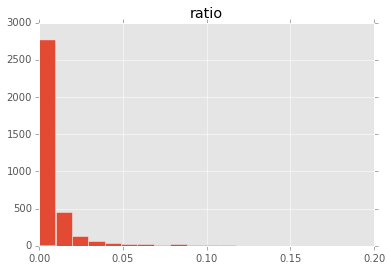

In [54]:
df_serv_dom.hist("ratio", bins=20)

% de personas de 14 a 25 años sin secundario, que asiste al secundario

In [55]:
query_asist_sec = """
RUNDEF programa 
    SELECTION INLINE,
        PROV 02

DEFINE RADIO.COUNTER
    AS COUNT PERSONA
    TYPE INTEGER

DEFINE PERSONA.ASISTSEC
    AS PERSONA.P08
    FOR ((PERSONA.P09 = 1 OR PERSONA.P09 = 2 OR PERSONA.P09 = 3
         OR (PERSONA.P09 = 4 AND PERSONA.P08 = 1)) AND PERSONA.EDAD >= 14 AND
         PERSONA.EDAD <= 25)
    TYPE INTEGER
    RANGE 1-3
    
TABLE T1
    AS AREALIST 
    OF RADIO, RADIO.COUNTER, PERSONA.ASISTSEC
"""

In [56]:
df_asist_sec = get_data_from_query("RADIO", query_asist_sec, redownload=False)
df_asist_sec.head()

,COUNTER,1,2,Total,CO_FRAC_RA
Código,,,,,
020010101,336,20,8,28,1_1_1
020010201,478,51,21,72,1_2_1
020010202,401,34,21,55,1_2_2
020010203,337,38,11,49,1_2_3
020010204,602,79,19,98,1_2_4


In [57]:
universo_relevante = df_asist_sec["Total"].sum()
personas_totales = df_asist_sec["COUNTER"].sum()
print universo_relevante, personas_totales, universo_relevante / personas_totales

172687.0 2890151.0 0.0597501653028


In [58]:
df_asist_sec["ratio"] = df_asist_sec["1"] / df_asist_sec["Total"]
df_asist_sec.head()

,COUNTER,1,2,Total,CO_FRAC_RA,ratio
Código,,,,,,
020010101,336,20,8,28,1_1_1,0.714286
020010201,478,51,21,72,1_2_1,0.708333
020010202,401,34,21,55,1_2_2,0.618182
020010203,337,38,11,49,1_2_3,0.775510
020010204,602,79,19,98,1_2_4,0.806122


In [59]:
df_asist_sec["1"].sum() / df_asist_sec["Total"].sum()

0.87295511532425718

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10ba20590>]], dtype=object)

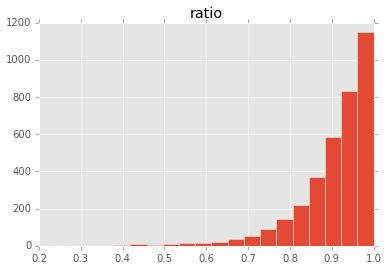

In [60]:
df_asist_sec.hist("ratio", bins=20)

*Criterio 3*

% de hogares con "piso precario"

In [61]:
df_piso = dfs_radio[11]
df_piso["ratio"] = (df_piso["Tierra o ladrillo suelto"] + df_piso["Otro"]) / df_piso["Total"]
df_piso.head()

,"Cerámica, baldosa, mosaico, mármol, madera o alfombrado",Cemento o ladrillo fijo,Tierra o ladrillo suelto,Otro,Total,CO_FRAC_RA,ratio
Código,,,,,,,
020010101,43,20,0,2,65,1_1_1,0.030769
020010201,47,95,14,5,161,1_2_1,0.118012
020010202,46,80,2,0,128,1_2_2,0.015625
020010203,29,73,1,1,104,1_2_3,0.019231
020010204,69,91,2,1,163,1_2_4,0.018405


In [62]:
(df_piso["Tierra o ladrillo suelto"].sum() + df_piso["Otro"].sum()) / df_piso["Total"].sum()

0.0071113452867231121

In [63]:
df_piso["ratio"].max(), df_piso["ratio"].mean(), df_piso["ratio"].min()

(0.77777777777777779, 0.0070729021688079267, 0.0)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10e2efc10>]], dtype=object)

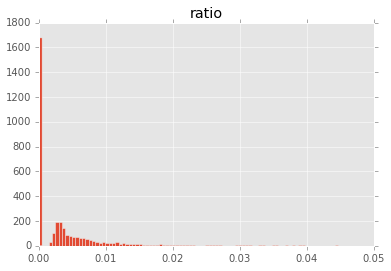

In [64]:
df_piso[df_piso["ratio"] < 0.05].hist("ratio", bins=100)

% de personas entre 18 y 29 años que usa computadora

In [65]:
query_joven_compu = """
RUNDEF programa 
    SELECTION INLINE,
        PROV 02

DEFINE RADIO.COUNTER
    AS COUNT PERSONA
    TYPE INTEGER

DEFINE PERSONA.USACOMPU
    AS PERSONA.P12
    FOR (PERSONA.EDAD >= 18 AND PERSONA.EDAD <= 29)
    TYPE INTEGER
    RANGE 1-2
    
TABLE T1
    AS AREALIST 
    OF RADIO, RADIO.COUNTER, PERSONA.USACOMPU
"""

In [66]:
df_joven_compu = get_data_from_query("RADIO", query_joven_compu, redownload=False)
df_joven_compu.head()

,COUNTER,1,2,Total,CO_FRAC_RA
Código,,,,,
020010101,336,46,14,60,1_1_1
020010201,478,91,45,136,1_2_1
020010202,401,58,47,105,1_2_2
020010203,337,64,25,89,1_2_3
020010204,602,124,35,159,1_2_4


In [67]:
universo_relevante = df_joven_compu["Total"].sum()
personas_totales = df_joven_compu["COUNTER"].sum()
print universo_relevante, personas_totales, universo_relevante / personas_totales

540727.0 2890151.0 0.187092992719


In [68]:
df_joven_compu["ratio"] = df_joven_compu["1"] / df_joven_compu["Total"]
df_joven_compu.head()

,COUNTER,1,2,Total,CO_FRAC_RA,ratio
Código,,,,,,
020010101,336,46,14,60,1_1_1,0.766667
020010201,478,91,45,136,1_2_1,0.669118
020010202,401,58,47,105,1_2_2,0.552381
020010203,337,64,25,89,1_2_3,0.719101
020010204,602,124,35,159,1_2_4,0.779874


In [69]:
df_joven_compu["1"].sum() / df_joven_compu["Total"].sum()

0.89974608258881095

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10e860c50>]], dtype=object)

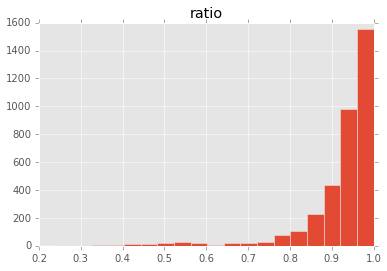

In [70]:
df_joven_compu.hist("ratio", bins=20)

*Criterio 4*

% de personas con desagüe a hoyo o pozo

In [71]:
df_desague = dfs_radio[12]

In [72]:
df_desague["ratio"] = (df_desague["Sólo a pozo ciego".decode("utf-8")] + 
                       df_desague["A hoyo, excavación en la tierra, etc.".decode("utf-8")]) / df_desague["Total"]
df_desague.head()

,A red pública (cloaca),A cámara séptica y pozo ciego,Sólo a pozo ciego,"A hoyo, excavación en la tierra, etc.",Total,CO_FRAC_RA,ratio
Código,,,,,,,
020010101,60,3,1,1,65,1_1_1,0.030769
020010201,124,2,8,0,134,1_2_1,0.059701
020010202,111,9,6,0,126,1_2_2,0.047619
020010203,87,9,3,0,99,1_2_3,0.030303
020010204,155,5,2,0,162,1_2_4,0.012346


In [73]:
(df_desague["Sólo a pozo ciego".decode("utf-8")].sum() + 
 df_desague["A hoyo, excavación en la tierra, etc.".decode("utf-8")].sum()) / df_desague["Total"].sum()

0.0040159304127576614

In [74]:
df_desague["ratio"].max(), df_desague["ratio"].mean(), df_desague["ratio"].min()

(0.75839999999999996, 0.0036487894407812569, 0.0)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10eed7410>]], dtype=object)

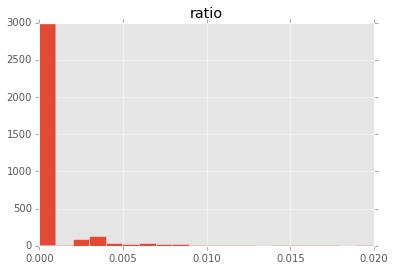

In [75]:
df_desague[df_desague["ratio"] < 0.02].hist("ratio", bins=20)

% de hogares con jefes con educación secundaria completa

In [76]:
query_jefe_secun = """
RUNDEF programa 
    SELECTION INLINE,
        PROV 02

DEFINE RADIO.COUNTER
    AS COUNT HOGAR
    TYPE INTEGER

DEFINE HOGAR.EDUCJEFE 
    AS PERSONA.P09
    FOR PERSONA.P01 = 1 
    RANGE 1-9
    TYPE INTEGER
    VARLABEL "Nivel educativo del jefe del hogar" 

DEFINE HOGAR.JEFETER
    AS PERSONA.P10
    FOR PERSONA.P01 = 1 
    RANGE 1-2
    TYPE INTEGER
    VARLABEL "Jefe de hogar terminó el nivel educativo" 

DEFINE HOGAR.JEFEUNIV
    AS (HOGAR.EDUCJEFE = 8 OR HOGAR.EDUCJEFE = 7 OR HOGAR.EDUCJEFE = 6 OR
        ((HOGAR.EDUCJEFE = 5 OR HOGAR.EDUCJEFE = 4) AND HOGAR.JEFETER = 1))
    TYPE INTEGER
    RANGE 0-1

TABLE T1
    AS AREALIST 
    OF RADIO, RADIO.COUNTER, HOGAR.JEFEUNIV
"""

In [77]:
df_jefe_secun = get_data_from_query("RADIO", query_jefe_secun, redownload=False)
df_jefe_secun.head()

,COUNTER,0,1,Total,CO_FRAC_RA
Código,,,,,
020010101,93,41,47,88,1_1_1
020010201,162,108,50,158,1_2_1
020010202,132,90,38,128,1_2_2
020010203,104,66,35,101,1_2_3
020010204,164,112,46,158,1_2_4


In [78]:
universo_relevante = df_jefe_secun["Total"].sum()
hogares_totales = df_jefe_secun["COUNTER"].sum()
print universo_relevante, hogares_totales, universo_relevante / hogares_totales

1141371.0 1152599.0 0.990258537445


In [79]:
df_jefe_secun["ratio"] = df_jefe_secun["1"] / df_jefe_secun["Total"]
df_jefe_secun.head()

,COUNTER,0,1,Total,CO_FRAC_RA,ratio
Código,,,,,,
020010101,93,41,47,88,1_1_1,0.534091
020010201,162,108,50,158,1_2_1,0.316456
020010202,132,90,38,128,1_2_2,0.296875
020010203,104,66,35,101,1_2_3,0.346535
020010204,164,112,46,158,1_2_4,0.291139


In [80]:
print df_jefe_secun["1"].sum() / df_jefe_secun["Total"].sum()

0.716206211652


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10eef25d0>]], dtype=object)

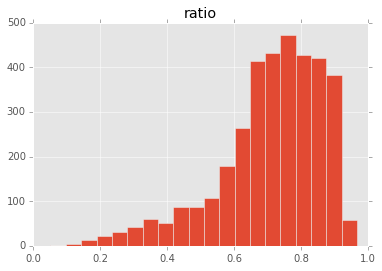

In [81]:
df_jefe_secun.hist("ratio", bins=20)

In [82]:
from scripts.nse import NSE

indicators = {
    "con_satisf": (0.6, indicators_radio["con_satisf"]),
    "pers_domestico": (0.03, df_serv_dom["ratio"]),
    "asist_secundario": (0.6, df_asist_sec["ratio"]),
    "jefes_univ": (0.4, df_educ_jefes["ratio"]),
    "piso_c3": (0.01, df_piso["ratio"]),
    "piso_c4": (0.99, df_piso["ratio"]),
    "joven_compu": (0.85, df_joven_compu["ratio"]),
    "desague": (0.1, df_desague["ratio"]),
    "jefe_secun": (0.85, df_jefe_secun["ratio"])
}

nse = NSE(indicators)
nse.calc(nse_alt)

In [83]:
nse_alt["hab"] = indicators_radio["hab"]
total = pd.pivot_table(nse_alt, values='hab', columns=["nse_alt"], aggfunc=np.sum).sum()
parcial = pd.pivot_table(nse_alt, values='hab', columns=["nse_alt"], aggfunc=np.sum)
serie_per = parcial / total
serie_per
#serie_per.plot()

nse_alt
1    0.048813
2    0.112873
3    0.592083
4    0.108028
5    0.081543
6    0.042207
7    0.014453
Name: hab, dtype: float64

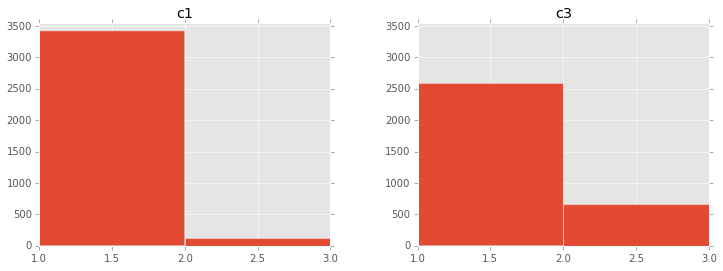

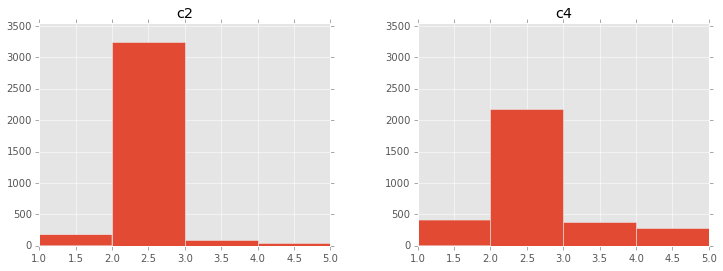

In [84]:
hists = np.append(nse_alt.hist(["c1", "c3"], bins=2, range=(1, 3), figsize=(12, 4))[0],
                  nse_alt.hist(["c2", "c4"], bins=4, range=(1, 5), figsize=(12, 4))[0])
hists = [hist.set_ylim((0, len(nse_alt))) for hist in hists]

(0, 3554)

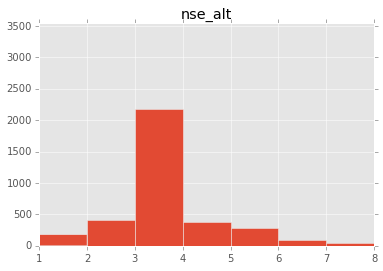

In [85]:
nse_alt.hist("nse_alt", bins=7, range=(1, 8))[0][0].set_ylim((0, len(nse_alt)))

In [86]:
indicators_radio["nse_alt"] = nse_alt["nse_alt"]

## 3. Calcular el área y densidad de cada shape

Se calcula la superficie de cada división de la CABA y la densidad poblacional.

In [87]:
def calc_areas(shp_path):
    areas = pd.DataFrame()
    for id_shape, shape in iter_shp_as_shapely(shp_path):
        areas.loc[id_shape, "AREA"] = shape.area
        areas.loc[id_shape, "area_km2"] = shape.area / 1000000
    return areas

def rebuild_index(caba_idx):
    if "_" in unicode(caba_idx):
        split = caba_idx.split("_")    
        census_idx = "02" + split[0].zfill(3)
        for elem in split[1:]:
            census_idx += elem.zfill(2)
    else:
        census_idx = "02" + unicode(caba_idx).zfill(3)
    return census_idx

def add_area_indicator(area_level, df):
    df.drop(["AREA", "area_km2"], 1, inplace=True, errors="ignore")
    area = calc_areas(get_division_path(AREA_LEVEL_SHP_NAME[area_level]))
    merged_df = df.merge(area, how="outer", left_on=IDS_GCBA[area_level], right_index=True)
    merged_df.index = map(rebuild_index, merged_df[IDS_GCBA[area_level]])
    return merged_df

In [88]:
indicators_radio = add_area_indicator("RADIO", indicators_radio)
indicators_frac = add_area_indicator("FRAC", indicators_frac)
indicators_comuna = add_area_indicator("DPTO", indicators_comuna)
indicators_caba["AREA"] = indicators_comuna.AREA.sum()
indicators_caba["area_km2"] = indicators_comuna.area_km2.sum()

In [89]:
# asegura que no hay divisiones con missings en "hab"
indicators_radio.hab = indicators_radio.hab.fillna(0)
indicators_frac.hab = indicators_frac.hab.fillna(0)
indicators_comuna.hab = indicators_comuna.hab.fillna(0)

In [90]:
# los missings por falta de población se toman como ceros, 
# para no afectar el cálculo de indicadores agregados
def set_missing_pop_to_zero(df):
    float_cols = df.select_dtypes(include=[np.float]).columns
    for col in float_cols:        
        for index in df[(df["hab"] == 0 | pd.isnull(df["hab"]))][col].index:
            value = df[df["hab"] == 0][col][index]
            if np.isnan(value):
                df.loc[index, col] = 0

map(set_missing_pop_to_zero, [indicators_radio, indicators_frac,
                              indicators_comuna, indicators_caba])

[None, None, None, None]

In [91]:
indicators_radio["hab_km2"] = indicators_radio["hab"] / indicators_radio["area_km2"]
indicators_frac["hab_km2"] = indicators_frac["hab"] / indicators_frac["area_km2"]
indicators_comuna["hab_km2"] = indicators_comuna["hab"] / indicators_comuna["area_km2"]

## Guardar indicadores en csv

In [92]:
indicators_radio.to_csv(get_indicators_path("RADIO"), encoding="utf-8")
indicators_frac.to_csv(get_indicators_path("FRAC"), encoding="utf-8")
indicators_comuna.to_csv(get_indicators_path("DPTO"), encoding="utf-8")
indicators_caba.to_csv(get_indicators_path("PROV"), encoding="utf-8")